# Suppl. Fig. 11 panel C, E

please first run dependency notebooks in the following directories:
- Fig5/panel_A/1.infected_enrichment
- Fig5/panel_A/2.control_enrichment
- Fig5/panel_A/3.aligned_umap
- Fig5/panel_C/Fig5_C_umap_with_leiden_labels.ipynb

In [1]:
import os, sys, copy
from pathlib import Path
import numpy as np
import pandas as pd
import umap
from scipy.spatial import procrustes
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shapely.geometry import Point
from shapely.ops import unary_union
from matplotlib.patches import PathPatch
from matplotlib.path import Path as mplPath
import anndata as ad

script_path = Path.cwd().parent.parent.parent.parent  / "script"
data_path = Path.cwd().parent.parent.parent.parent  / "data"
sys.path.append(str(script_path))

from pyseus.plotting import plotly_umap as pu
from utils import *
from utils.label_processing import attach_annotations
from external import clustering_workflows
from utils.Jaccard_coefficient import *

output_folder = Path.cwd() / "output"
os.makedirs(output_folder, exist_ok=True)

plt.rcParams["pdf.fonttype"] = 42

c:\Users\duo.peng\Documents\Organelle_IP_analyses_and_figures_revision\notebooks\Supplementary_figures\Suppl_fig11\panel_C


In [2]:
%store -r fig5_timestamp
print(f"Timestamp: {fig5_timestamp}")

Timestamp: 2023-10-21-for-figures


## project the virus proteins onto the aligned umap


### make a new umap using virus proteins + infected samples

In [3]:
# prepare data
# read the aligned UMAP
merged = pd.read_csv(Path.cwd().parent.parent.parent / "Fig5" / "panel_A" / "3.aligned_umap" / "output" / "2023-10-21-for-figures_AlignedUMAP_embeddings_and_distances.csv", index_col=None)

# read the virus proteins
virus_df_raw = pd.read_csv(Path.cwd().parent.parent.parent / "Fig5" / "panel_A" / "1.infected_enrichment" / "output" / "enrichment_and_volcano_tables" /"2023-10-21-for-figures_inf_enrichment_table_NOC_prop.csv",  header=[0, 1], index_col=0, low_memory=False)
virus_df = virus_df_raw.droplevel(0, axis=1)
print(f"enrichment_table_NOC dimensions:\n{virus_df.shape}")
# subset the virus df, keeping virus protein + proteins in the aligned UMAP
virus_df = virus_df[ (virus_df["Majority protein IDs"].isin(merged["Majority protein IDs"]))
                     | (virus_df["Protein IDs"].str.contains("OC43"))]

print(f'after keeping proteins in the aligned umap and virus proteins:\n{virus_df.shape}')
# subset the virus df, keeping the infected samples and their NOCs
inf = [i for i in merged.columns if i.endswith("_Infected")]
virus_df = virus_df[inf]
print(f'after keeping infected samples:\n{virus_df.shape}')
# scale the table for umap
virus_scaled = pu.scale_table(matrix=virus_df.copy().fillna(0).to_numpy(), method='standard')
print(f"virus_scaled shape:\n{virus_scaled.shape}")

enrichment_table_NOC dimensions:
(8376, 51)
after keeping proteins in the aligned umap and virus proteins:
(8037, 51)
after keeping infected samples:
(8037, 28)
virus_scaled shape:
(8037, 28)


In [4]:
# make a umap using infected samples + the virus proteins
virus_umap = umap.UMAP(n_neighbors=20,
                        metric="euclidean",
                        min_dist=0.1,
                        n_components = 2,
                        random_state=42,    
                        verbose = False).fit_transform(virus_scaled)
virus_df["Protein IDs"] = virus_df_raw.droplevel(0, axis=1)["Protein IDs"]
virus_df["Majority protein IDs"] = virus_df_raw.droplevel(0, axis=1)["Majority protein IDs"]
virus_df["Gene names"] = virus_df_raw.droplevel(0, axis=1)["Gene names"]
virus_df["umap_1"] = list(virus_umap[:, 0])
virus_df["umap_2"] = list(virus_umap[:, 1])

# save the virus umap to file
virus_df.to_csv(output_folder / f"umap_with_virus_proteins.csv")

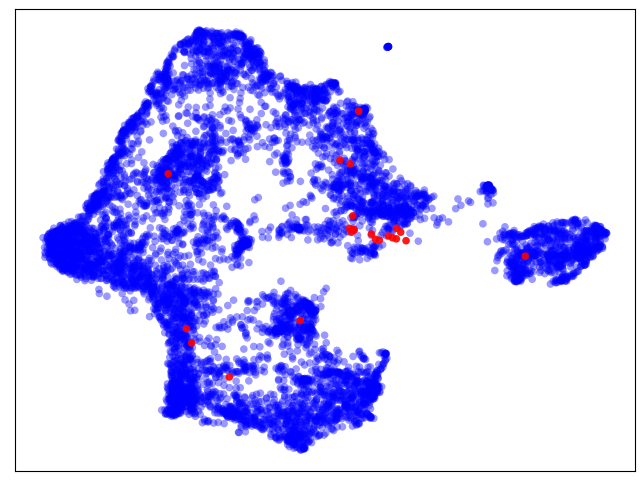

In [5]:
# visualize the umap made with infected samples + the virus proteins

# add a column where the virus proteins are labeled
virus_df["protein_source"] = virus_df["Protein IDs"].apply(lambda x: "OC43_protein" if "OC43" in x else "host_protein")

virus_only = virus_df[virus_df["Protein IDs"].str.contains("OC43")]
host_only = virus_df[~virus_df["Protein IDs"].str.contains("OC43")]

# Plot the two embeddings as scatter plots
colorDict = {"OC43_protein": "red", "host_protein": "blue"}
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    host_only["umap_1"], host_only["umap_2"],
    c=[colorDict[cat] for cat in host_only[f"protein_source"]],
    s=120, alpha=0.4, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.scatter(
    virus_only["umap_1"], virus_only["umap_2"],
    c=[colorDict[cat] for cat in virus_only[f"protein_source"]],
    s=120, alpha=0.9, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig(os.path.join("output", "inf_umap_colored_by_GO_CC.pdf"), format="pdf")
plt.show()

### adjust the range of the new umap coordinates to match that of the aligned umap (in preparation for projection)

In [6]:
# range of the new umap coordinates (with virus proteins)  
print(f"range of umap coordinates (inf + virus proteins):\n{virus_df['umap_1'].min(), virus_df['umap_1'].max()}")
print(f"{virus_df['umap_2'].min(), virus_df['umap_2'].max()}")


range of umap coordinates (inf + virus proteins):
(-4.855353, 7.1967745)
(-2.0159981, 8.571013)


In [7]:
# range of alignedUMAP_coords (infected)

jointUMAP_inf_1 = merged["JointUMAP_inf_1"]
jointUMAP_inf_2 = merged["JointUMAP_inf_2"]

jointUMAP_uninf_1 = merged["JointUMAP_uninf_1"]
jointUMAP_uninf_2 = merged["JointUMAP_uninf_2"]

# range of umap coordinates
print(f"range of umap coordinates (aligned, infection side):\n{min(jointUMAP_inf_1), max(jointUMAP_inf_1)}")
print(f"{min(jointUMAP_inf_2), max(jointUMAP_inf_2)}")

range of umap coordinates (aligned, infection side):
(-6.7988577, 6.173023)
(-5.930825, 5.452529)


In [8]:
# flip the axes and check the range again
flip = True
if flip == True:
    jointUMAP_inf_1 = [-i for i in jointUMAP_inf_1]
    jointUMAP_inf_2 = [-i for i in jointUMAP_inf_2]
    jointUMAP_uninf_1 = [-i for i in jointUMAP_uninf_1]
    jointUMAP_uninf_2 = [-i for i in jointUMAP_uninf_2]

print(f"range of umap coordinates (aligned, infection side):\n{min(jointUMAP_inf_1), max(jointUMAP_inf_1)}")
print(f"{min(jointUMAP_inf_2), max(jointUMAP_inf_2)}")

range of umap coordinates (aligned, infection side):
(-6.173023, 6.7988577)
(-5.452529, 5.930825)


In [9]:
# adjust the range of the jointUMAP coordinates to match the range of the virus umap coordinates
def rescale_list(input_list, original_min, original_max, desired_min, desired_max):
    return [desired_min + ((x - original_min) * (desired_max - desired_min) / (original_max - original_min)) for x in input_list]


jointUMAP_inf_1_rescale = rescale_list(jointUMAP_inf_1, min(jointUMAP_inf_1), max(jointUMAP_inf_1), virus_df['umap_1'].min(), virus_df['umap_1'].max())
jointUMAP_inf_2_rescale = rescale_list(jointUMAP_inf_2, min(jointUMAP_inf_2), max(jointUMAP_inf_2), virus_df['umap_2'].min(), virus_df['umap_2'].max())
jointUMAP_uninf_1_rescale = rescale_list(jointUMAP_uninf_1, min(jointUMAP_uninf_1), max(jointUMAP_uninf_1), virus_df['umap_1'].min(), virus_df['umap_1'].max())
jointUMAP_uninf_2_rescale = rescale_list(jointUMAP_uninf_2, min(jointUMAP_uninf_2), max(jointUMAP_uninf_2), virus_df['umap_2'].min(), virus_df['umap_2'].max())

print(f"range of umap coordinates (aligned, infection side):\n{min(jointUMAP_inf_1_rescale), max(jointUMAP_inf_1_rescale)}")
print(f"{min(jointUMAP_inf_2_rescale), max(jointUMAP_inf_2_rescale)}")
print(f"range of umap coordinates (aligned, uninfected side):\n{min(jointUMAP_uninf_1_rescale), max(jointUMAP_uninf_1_rescale)}")
print(f"{min(jointUMAP_uninf_2_rescale), max(jointUMAP_uninf_2_rescale)}")


range of umap coordinates (aligned, infection side):
(-4.855352878570557, 7.196774959564209)
(-2.015998125076294, 8.57101321220398)
range of umap coordinates (aligned, uninfected side):
(-4.855352878570557, 7.196774959564209)
(-2.015998125076294, 8.57101321220398)


In [10]:
# save aligned umap embeddings to csv

merged["JointUMAP_uninf_1"] = jointUMAP_uninf_1_rescale
merged["JointUMAP_uninf_2"] = jointUMAP_uninf_2_rescale
merged["JointUMAP_inf_1"] = jointUMAP_inf_1_rescale
merged["JointUMAP_inf_2"] = jointUMAP_inf_2_rescale

# update coordinates
save_path = output_folder / f"{fig5_timestamp}_AlignedUMAP_embeddings_and_distances.csv"
merged.to_csv(save_path, index=False)

### compute the projection of virus proteins onto the aligned umap (infection side)

In [11]:
# perform Procrustes analysis to find the best projection
shared_proteins = merged["Protein IDs"].to_list()


alignedUMAP_coords = np.array([jointUMAP_inf_1_rescale,
                               jointUMAP_inf_2_rescale]).T
virus_umap_common = virus_df[virus_df["Protein IDs"].isin(shared_proteins)] # get the common proteins to compute the projection (can't have virus proteins in this step)
virus_umap_coords = np.array([virus_umap_common['umap_1'], 
                              virus_umap_common['umap_2']]).T

# Function to compute transformation using Procrustes analysis
def compute_transformation(UMAP1_common, UMAP2_common):
    # Perform Procrustes analysis
    mtx1, mtx2, disparity = procrustes(UMAP1_common, UMAP2_common)
    
    # Compute the transformation matrix
    translation = np.mean(mtx1, axis=0) - np.mean(mtx2, axis=0)
    scale = np.std(mtx1) / np.std(mtx2)
    
    # Compute the rotation matrix
    rotation_matrix = np.linalg.lstsq(mtx2, mtx1, rcond=None)[0]
    
    return translation, scale, rotation_matrix

# Function to compute transformation using Procrustes analysis
def compute_transformation_v2(UMAP1_common, UMAP2_common):
    # Perform Procrustes analysis
    mtx1, mtx2, disparity = procrustes(UMAP1_common, UMAP2_common)
    
    # Calculate the optimal rotation matrix using SVD
    U, _, Vt = np.linalg.svd(mtx2.T @ mtx1)
    rotation_matrix = U @ Vt
    
    # Calculate scaling and translation
    scale = np.std(mtx1) / np.std(mtx2)
    translation = np.mean(mtx1, axis=0) - scale * np.mean(mtx2 @ rotation_matrix, axis=0)
    
    return translation, scale, rotation_matrix

# Perform Procrustes analysis to find the best transformation
# we are using the alignedUMAP(infected) as the reference, and the virus umap will be transformed to fit into the reference 
translation, scale, rotation_matrix = compute_transformation(alignedUMAP_coords, virus_umap_coords)

In [12]:
# project the virus proteins using the transformation 
# Apply the transformation to the extra points
def apply_transformation(points, translation, scale, rotation_matrix):
    # Apply rotation and scaling
    transformed_points = points @ rotation_matrix * scale
    
    # Apply translation
    transformed_points += translation
    
    return transformed_points

virus_points = virus_df[virus_df["Protein IDs"].str.contains("OC43")].copy()
virus_points_coords = virus_points[["umap_1", "umap_2"]].to_numpy()
virus_points_projected = apply_transformation(virus_points_coords, translation, scale, rotation_matrix)

virus_points["umap_1_projected"] = virus_points_projected[:, 0]
virus_points["umap_2_projected"] = virus_points_projected[:, 1]

In [13]:
virus_points_temp = virus_points.copy()[["Protein IDs", "Majority protein IDs", "Gene names", "umap_1_projected", "umap_2_projected"]]
# rename the projected columns as joint UMAP infected 
virus_points_temp.rename(columns={"umap_1_projected": "JointUMAP_inf_1", "umap_2_projected": "JointUMAP_inf_2"}, inplace=True)
# add dummy columns for the joint UMAP uninfected
virus_points_temp["JointUMAP_uninf_1"] = 0
virus_points_temp["JointUMAP_uninf_2"] = 0

In [14]:
# add virus proteins to the aligned umap
merged_with_virus = merged.copy()
merged_with_virus = merged_with_virus[["Protein IDs", "Majority protein IDs", "Gene names"]] # keep the metadata
merged_with_virus["JointUMAP_uninf_1"] = jointUMAP_uninf_1_rescale # add aligned umap coordinates
merged_with_virus["JointUMAP_uninf_2"] = jointUMAP_uninf_2_rescale
merged_with_virus["JointUMAP_inf_1"] = jointUMAP_inf_1_rescale
merged_with_virus["JointUMAP_inf_2"] = jointUMAP_inf_2_rescale


In [15]:
# add the virus proteins to the merged umap by concatenating the two dataframes
merged_with_virus = pd.concat([merged_with_virus, virus_points_temp], ignore_index=True)

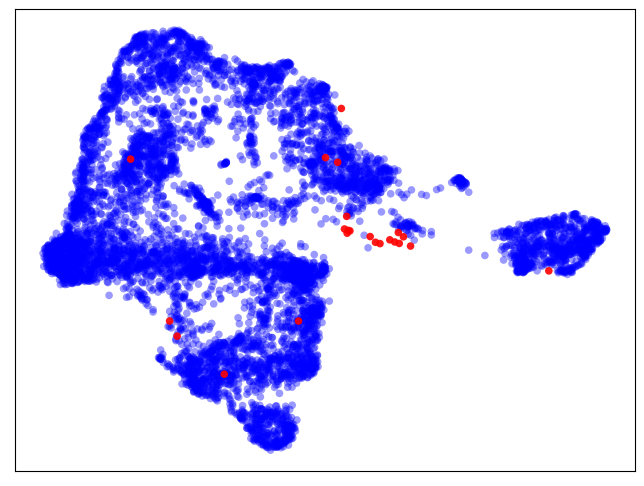

In [16]:
# visualize the aligned UMAP with the virus proteins
merged_with_virus["protein_source"] = merged_with_virus["Protein IDs"].apply(lambda x: "OC43_protein" if "OC43" in x else "host_protein")
virus_only = merged_with_virus[merged_with_virus["Protein IDs"].str.contains("OC43")]
host_only = merged_with_virus[~merged_with_virus["Protein IDs"].str.contains("OC43")]

# Plot the two embeddings as scatter plots
colorDict = {"OC43_protein": "red", "host_protein": "blue"}
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    host_only["JointUMAP_inf_1"], host_only["JointUMAP_inf_2"],
    c=[colorDict[cat] for cat in host_only[f"protein_source"]],
    s=120, alpha=0.4, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.scatter(
    virus_only["JointUMAP_inf_1"], virus_only["JointUMAP_inf_2"],
    c=[colorDict[cat] for cat in virus_only[f"protein_source"]],
    s=120, alpha=0.9, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig(os.path.join("output", "inf_umap_colored_by_GO_CC.pdf"), format="pdf")
plt.show()

### save the aligned umap (now with projected virus proteins)

In [17]:
# save the merged umap with virus proteins to file
merged_with_virus.to_csv(output_folder / f"{fig5_timestamp}_AlignedUMAP_embeddings_with_virus_proteins_projections.csv")

In [18]:
# create a subset of virus proteins only
virus_proteins_umap_table = merged_with_virus[merged_with_virus["Protein IDs"].str.contains("OC43")]

## plot the aligned umap (infected side) with projected virus proteins (panel C)

In [19]:
# read the aligned UMAP (with leiden clusters)
df = pd.read_csv(Path.cwd().parent.parent.parent / "Fig5" / "panel_C" / "output" / f"{fig5_timestamp}_umap_table.csv", index_col=None)

# update the coordinates with once that were recentered
df["JointUMAP_inf_1"] = host_only["JointUMAP_inf_1"]
df["JointUMAP_inf_2"] = host_only["JointUMAP_inf_2"]

In [20]:
# define cluster colors
colorDict = {
    "nucleus": "#DB5F57",
    "cytosol": "#A2CE5A",
    "mitochondrion": "#59B6DC",
    "ER": "#DB9C58",
    "plasma memb. & actin": "#B96EAD",
    "endo-lysosome & trans-Golgi": "#DBD956",
    "ERGIC/Golgi": "#6BC7BB",
    "translation/RNA granules": "#707070",
    "peroxisome": "#EC008C",
    "COPI vesicle": "red",
    "centrosome": "#955FA7",
    "unlabelled": "grey",
    "OC43_protein":"#000000",
    "unclassified": "#cccccc"
}

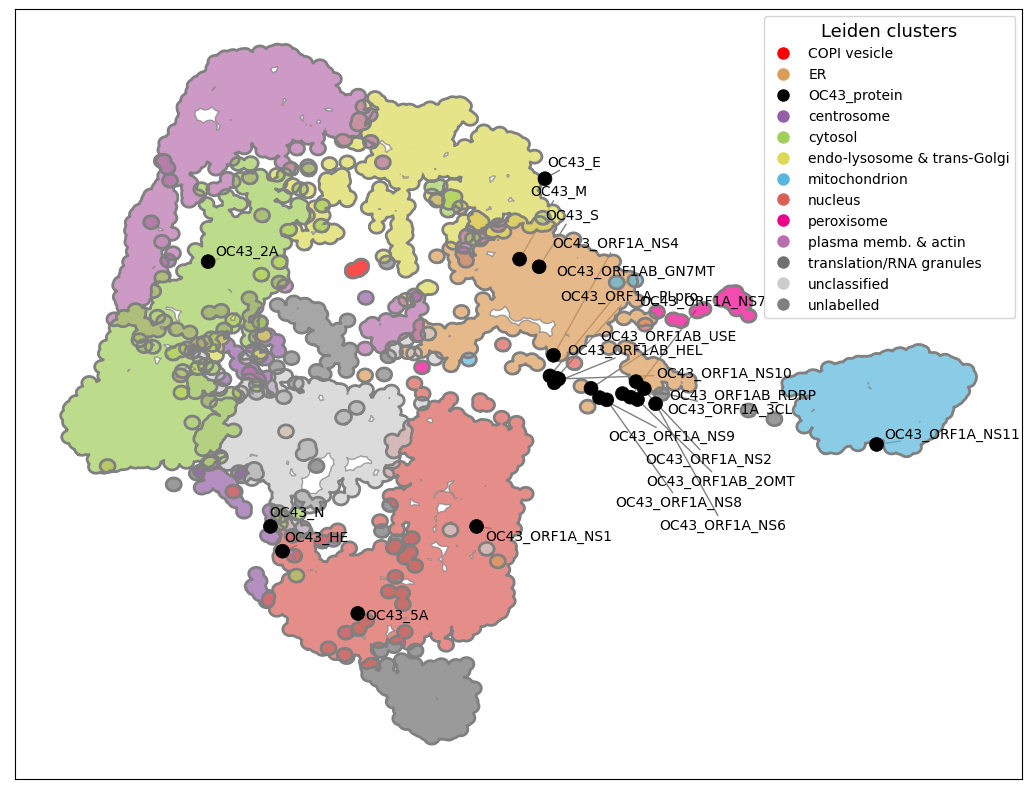

In [21]:
fig, ax = plt.subplots(figsize=(13, 10))

# Scatter plot for host proteins
ax.scatter(
    df["JointUMAP_inf_1"], df["JointUMAP_inf_2"],
    c=[colorDict[cat] for cat in df["cluster_annot_inf"]],
    s=0, alpha=0.6, marker=".", linewidths=0, edgecolor=None, zorder=1
)

# --- Cluster Boundary Plotting Code --- #

# Function to create circle shapes around points
def create_circles(points, radius=0.1):
    circles = [Point(xy).buffer(radius) for xy in points]
    return circles

# Function to convert a Shapely polygon to a Matplotlib patch
def polygon_to_patch(polygon, **kwargs):
    if polygon.is_empty:
        return None
    vertices = []
    codes = []
    # Exterior ring
    x, y = polygon.exterior.xy
    coords = np.column_stack((x, y))
    vertices.extend(coords)
    codes.extend([mplPath.MOVETO] + [mplPath.LINETO]*(len(coords)-2) + [mplPath.CLOSEPOLY])
    # Interiors (holes)
    for interior in polygon.interiors:
        x, y = interior.xy
        coords = np.column_stack((x, y))
        vertices.extend(coords)
        codes.extend([mplPath.MOVETO] + [mplPath.LINETO]*(len(coords)-2) + [mplPath.CLOSEPOLY])
    path = mplPath(vertices, codes)
    patch = PathPatch(path, **kwargs)
    return patch

# Get all unique clusters from both DataFrames
clusters_df = df["cluster_annot_inf"].unique()
all_clusters = set(clusters_df)

# Plot cluster boundaries with filled polygons
for cluster in all_clusters:
    # Get points from df and virus_proteins_umap_table
    cluster_points_df = df[df["cluster_annot_inf"] == cluster][["JointUMAP_inf_1", "JointUMAP_inf_2"]].values
    cluster_points_virus = virus_proteins_umap_table[
        virus_proteins_umap_table["protein_source"] == cluster
    ][["JointUMAP_inf_1", "JointUMAP_inf_2"]].values
    cluster_points = np.vstack([cluster_points_df, cluster_points_virus])
    if cluster_points.size == 0:
        continue
    # Create circles
    circles = create_circles(cluster_points, radius=0.1)
    # Compute union of circles
    union_shape = unary_union(circles)
    # Get color for the cluster
    color = colorDict.get(cluster, 'black')

    # Determine if the cluster is virus-only
    is_virus_only = cluster_points_df.size == 0 and cluster_points_virus.size > 0

    # Set edgecolor and decide on plotting boundary based on cluster type
    if is_virus_only:
        edgecolor = 'none'  # Remove boundary outline for virus-only clusters
        plot_boundary = False  # Do not plot boundary lines
    else:
        edgecolor = 'grey'  # Use grey boundary for host clusters
        plot_boundary = True  # Plot boundary lines

    # Plot the boundary with filled polygons
    if union_shape.is_empty:
        continue
    # Collect all polygons
    polygons = []
    if union_shape.geom_type == 'Polygon':
        polygons.append(union_shape)
    elif union_shape.geom_type in ['MultiPolygon', 'GeometryCollection']:
        for geom in union_shape.geoms:
            if geom.geom_type == 'Polygon':
                polygons.append(geom)
    # For each polygon, create a PathPatch and add to the axes
    for poly in polygons:
        patch = polygon_to_patch(
            poly,
            facecolor=color,
            edgecolor=edgecolor,  # Set edgecolor based on cluster type
            alpha=0.70,
            zorder=2
        )
        if patch:
            ax.add_patch(patch)
        # Optionally, plot the boundary lines
        if plot_boundary:
            x_boundary, y_boundary = poly.exterior.xy
            ax.plot(x_boundary, y_boundary, color='grey', linewidth=2, zorder=3)

# --- Plot Virus Proteins After Boundaries --- #

# Scatter plot for virus proteins (move this code here)
ax.scatter(
    virus_proteins_umap_table["JointUMAP_inf_1"], virus_proteins_umap_table["JointUMAP_inf_2"],
    c=[colorDict[cat] for cat in virus_proteins_umap_table["protein_source"]],
    s=100, alpha=1.0, marker="o", linewidths=0.5, edgecolor='black', zorder=4  # Increased zorder
)

# --- Add Text Labels to virus proteins --- #

# Add text labels to virus proteins
x = virus_proteins_umap_table["JointUMAP_inf_1"].tolist()
y = virus_proteins_umap_table["JointUMAP_inf_2"].tolist()
labels = virus_proteins_umap_table["Protein IDs"].tolist()

# Handle duplicated virus names by adding a suffix
seen = {}
for i in range(len(labels)):
    item = labels[i]
    if item not in seen:
        seen[item] = 1
    else:
        seen[item] += 1
        labels[i] = f"{item}_{seen[item]}"

# Add text labels to the plot
texts = []
for i in range(len(x)):
    texts.append(ax.text(x[i], y[i], labels[i], fontsize=10, zorder=5))  # Increased zorder

# Adjust text labels to avoid overlap
adjust_text(
    texts, only_move={'points': 'y', 'text': 'y'},
    arrowprops=dict(arrowstyle='-', color='gray'),
    force_text=0.5, expand=(1.2, 1.4)
)

# --- Legend and Aesthetics --- #

# Create a custom legend including all clusters
unique_categories = np.unique(
    np.concatenate((df["cluster_annot_inf"].unique(), virus_proteins_umap_table["protein_source"].unique()))
)
legend_handles = [
    Line2D(
        [0], [0], marker='o', color='w', label=cat,
        markersize=10, markerfacecolor=colorDict.get(cat, 'black')
    )
    for cat in unique_categories
]
ax.legend(handles=legend_handles, title="Leiden clusters", loc="best", fontsize=10, title_fontsize='13')

# Hide axis labels and ticks
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Save and show the plot
plt.savefig(os.path.join("output", "inf_umap_colored_by_GO_CC_with_boundaries.pdf"), format="pdf")
plt.show()


## compute consensus localization for the virus proteins ((panel E)

In [22]:
# prepare a dataframe with both host and virus proteins

# prep for df concatenation, add empty columns to match u_df
for col in df.columns:
    if col not in virus_proteins_umap_table.columns:
        if col == "cluster_annot_inf_raw" or col == "cluster_annot_inf_raw":
            virus_proteins_umap_table[col] = "OC43_proteins"

# concatenate the two dataframes
df = pd.concat([df, virus_proteins_umap_table], ignore_index=True)
df["cluster_annot_inf_raw"].replace("OC43_proteins", np.nan, inplace=True)

# fill in some missing values
df["Gene_name_canonical"] = df.copy()["Gene_name_canonical"].fillna(df["Protein IDs"])

In [23]:
# add virus quants (from infected quants) to the concatenated df

# read in the quants
quants = virus_df

# fill in the quants
infected_cols = [i for i in df.columns if "Infected" in i]
for idx, row in df.iterrows():
    prot_ID = row["Protein IDs"]
    if "OC43" in prot_ID:
        # find the index of this protein in quants
        index_lst = quants.index[quants['Protein IDs'] == prot_ID].tolist()
        if len(index_lst) == 1:
            for col in infected_cols:
                df.at[idx,col] = quants.at[index_lst[0],col]
        else:
            print(f"{prot_ID} is duplicated in quants") 

In [24]:
# computer kNN graph

# prepare adata object
quants_inf = df[infected_cols]
quants_inf.fillna(0, inplace=True)

# generating AnnData
adata_inf = ad.AnnData(quants_inf, dtype=np.float32)

adata_inf.var_names = infected_cols
adata_inf.obs_names = df["Protein IDs"].to_list()
adata_inf.obs["Protein IDs"] = df["Protein IDs"].to_list()
adata_inf.obs["Majority protein IDs"] = df["Majority protein IDs"].to_list()
adata_inf.obs["Gene_name_canonical"] = df["Gene_name_canonical"].to_list()
adata_inf.obs["cluster_annot_inf_raw"] = df["cluster_annot_inf_raw"].to_list()

adata_inf

# compute kNN graph
adata = adata_inf.copy()
kNN_obj = clustering_workflows.ClusteringWorkflow(adata=copy.deepcopy(adata))
# preprocessing
kNN_obj.preprocess(n_pcs=None)
# compute nearest neighbor graph
kNN_obj.calculate_neighbors(n_pcs=None, n_neighbors=20)
adata = kNN_obj.adata


c:\Users\duo.peng\Anaconda3\envs\OrgIP2\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



In [25]:
# compute consensus annotation for virus proteins

# prepare an annotation dataframe
annot_df = pd.DataFrame(
    list(zip(
            adata.obs["Majority protein IDs"].to_list(),
            adata.obs["Gene_name_canonical"].to_list(),
            adata.obs["cluster_annot_inf_raw"].to_list(),
        )),
    columns=["Majority protein IDs", "Gene_name_canonical", "cluster_annot_inf_raw"],
)

# initialize columns to store the neighborhood consensus, the neighborhood, and the neighbors
df["neighborhood_consensus"] = np.nan
df["neighborhood_consensus"] = df["neighborhood_consensus"].astype(str)
df["neighborhood"] = np.nan
df["neighborhood"] = df["neighborhood"].astype(object)
df["neighbors"] = np.nan
df["neighbors"] = df["neighbors"].astype(object) 

for idx, row in df.iterrows():
    if "OC43" in row["Protein IDs"]:
        gene = row["Gene_name_canonical"]
        neighbor_list, neighbor_annot_list = gene_neighbor_annots(gene_name=gene, adata=adata, annot_df=annot_df, gene_name_col="Gene_name_canonical", annot_col="cluster_annot_inf_raw")
        # get the most common annotation in the neighbor annotation
        _counter = Counter(neighbor_annot_list)
        most_common_annot = None
        second_common_annot = None
        if len(_counter) >= 2: # more than 2 unique annotations in the neighborhood
            most_common_annot = _counter.most_common(1)[0][0]
            second_common_annot = _counter.most_common(2)[1][0]

            # if the most common annotation is NaN, then check the count difference between the most common and the second common
            if pd.isna(most_common_annot):
                #check the count difference between the most common and the second common
                nan_count = _counter.most_common(1)[0][1]
                second_common_count = _counter.most_common(2)[1][1]
                # if the difference is less than 30% of the highest count (NaN count), then use the second common
                if nan_count - second_common_count  <= 0.3 * nan_count:
                    most_common_annot = second_common_annot
                else: # otherwise, label as unclassified
                    most_common_annot = "unclassified"

            # break ties
            if _counter.most_common(1)[0][1] == _counter.most_common(2)[1][1]:
                if "ER" in [most_common_annot, second_common_annot]:
                    most_common_annot = "ER"

        elif len(_counter) == 1: # only one unique annotation in the neighborhood
            most_common_annot = _counter.most_common(1)[0][0]

        df.at[idx, "neighborhood_consensus"] = most_common_annot
        df.at[idx, "neighborhood"] = [list(_counter.items())]
        df.at[idx, "neighbors"] = dict(zip(neighbor_list, neighbor_annot_list)) 

In [26]:
virus_consensus = df[df["Protein IDs"].str.contains("OC43")]
virus_consensus = virus_consensus[["Protein IDs", "neighborhood_consensus", "neighborhood"]]
virus_consensus = virus_consensus.sort_values(by='neighborhood_consensus', key=lambda col: col.str.lower())
virus_consensus.rename(columns={"Protein IDs": "OC43 viral protein", "neighborhood_consensus": "consensus localization"}, inplace=True)
pd.set_option('display.max_colwidth', None)
virus_consensus


,OC43 viral protein,consensus localization,neighborhood
8014,OC43_2A,cytosol,"[[(cytosol, 23), (nucleus, 6), (endo-lysosome & trans-Golgi, 1), (nan, 1)]]"
8016,OC43_E,endo-lysosome & trans-Golgi,"[[(endo-lysosome & trans-Golgi, 31)]]"
8018,OC43_M,endo-lysosome & trans-Golgi,"[[(endo-lysosome & trans-Golgi, 14), (ER, 12), (plasma memb. & actin, 1), (centrosome, 3), (mitochondrion, 1), (nucleus, 1), (nan, 1)]]"
8034,OC43_ORF1AB_RDRP,ER,"[[(nucleus, 1), (peroxisome, 2), (ER, 9), (mitochondrion, 1), (nan, 11)]]"
8033,OC43_ORF1AB_HEL,ER,"[[(ER, 24), (nucleus, 1), (plasma memb. & actin, 2), (translation/RNA granules, 1), (nan, 9)]]"
8032,OC43_ORF1AB_GN7MT,ER,"[[(ER, 16), (plasma memb. & actin, 1), (mitochondrion, 1), (nan, 5)]]"
8030,OC43_ORF1A_PLpro,ER,"[[(ER, 28), (nan, 9)]]"
8029,OC43_ORF1A_NS9,ER,"[[(nucleus, 1), (ER, 9), (peroxisome, 3), (mitochondrion, 2), (translation/RNA granules, 2), (plasma memb. & actin, 3), (nan, 10)]]"
8028,OC43_ORF1A_NS8,ER,"[[(nucleus, 5), (ER, 9), (mitochondrion, 2), (nan, 9)]]"
8035,OC43_ORF1AB_USE,ER,"[[(nucleus, 1), (ER, 8), (mitochondrion, 1), (translation/RNA granules, 2), (nan, 11)]]"


In [27]:
virus_consensus.to_csv(output_folder / f"{fig5_timestamp}_OC43_virus_proteins_consensus_localization.csv")